# MTM Air Quality

## Load Libs


In [ ]:
import os
from datetime import datetime as dt

import icecream
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from flax import nnx
from icecream import ic
from sklearn.preprocessing import StandardScaler

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
from transformers import BertTokenizerFast, FlaxBertModel

import hephaestus as hp
import hephaestus.training as ht

jax.config.update(
    "jax_default_matmul_precision", "float32"
)  # One of those things that you set and don't ask questions about.

icecream.install()
ic_disable = True  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = FlaxBertModel.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: {('pooler', 'dense', 'kernel'), ('pooler', 'dense', 'bias')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load and Process Data


In [3]:
# Load and preprocess the dataset (assuming you have a CSV file)
# Select numeric columns

csvs = [
    os.path.join("./data/air_quality/", f)
    for f in os.listdir("./data/air_quality/")
    if f.endswith(".csv")
]
dfs = [pd.read_csv(csv) for csv in csvs]
df = pd.concat(dfs, ignore_index=True)
del dfs
time_cols = ["year", "month", "day", "hour"]
df = df.sort_values(time_cols).reset_index(drop=True).drop("No", axis=1)
# Convert time columns to strings
for col in time_cols:
    df[col] = df[col].astype(str)
# replace . and lower case column names
df.columns = [c.replace(".", "_").lower() for c in df.columns]
# df = df.dropna()
df_no_na = df.dropna()
print(df.shape)
df.dropna(subset=["pm2_5"], inplace=True)
print(df.shape)
df = df.reset_index(drop=True)

df["idx"] = df.index // 32
# df = df.drop(["year", "month", "day", "hour"], axis=1)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
numeric_cols.remove("idx")  # Remove idx column from scaling

# Create and fit scaler
scale_data = True
if scale_data:
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
df.head()

(420768, 17)
(412029, 17)


,year,month,day,hour,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wd,wspm,station,idx
0,2013,3,1,0,-0.888287,-1.053950,-0.455258,-0.646087,-0.716585,-0.092324,-1.241098,1.167559,-1.540361,-0.078233,NNW,2.147009,Wanliu,0
1,2013,3,1,0,-0.937779,-1.097559,-0.085294,-0.873762,-0.802742,0.208013,-1.241098,1.167559,-1.540361,-0.078233,NNW,2.147009,Guanyuan,0
2,2013,3,1,0,-0.913033,-0.944926,-0.501504,NaN,-0.371959,0.543684,-1.171139,0.986054,-1.525871,-0.078233,NW,2.147009,Gucheng,0
3,2013,3,1,0,-0.937779,-1.097559,-0.593995,NaN,-0.888898,0.437683,-1.381015,0.957395,-1.605567,-0.078233,E,-0.985280,Dingling,0
4,2013,3,1,0,-0.875915,-1.043047,-0.455258,-0.959140,-0.888898,0.084345,-1.153650,1.062477,-1.554851,-0.078233,WNW,0.219446,Wanshouxigong,0


In [4]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['Nongzhanguan',
 '27',
 'WNW',
 '7',
 'SSW',
 'Shunyi',
 '5',
 'WSW',
 '10',
 '16',
 '23',
 'Dingling',
 '11',
 '6',
 '19',
 'Wanliu',
 '12',
 'ENE',
 '31',
 '15',
 'NE',
 '18',
 '2015',
 '2014',
 '14',
 'Changping',
 '9',
 '29',
 'N',
 'W',
 'SW',
 'Aotizhongxin',
 '3',
 '0',
 'Gucheng',
 '17',
 '30',
 'ESE',
 'Wanshouxigong',
 '26',
 '25',
 'NW',
 '20',
 'E',
 'Dongsi',
 '2013',
 'NNW',
 'S',
 '24',
 '28',
 '2',
 '22',
 '2016',
 'NNE',
 'SSE',
 '13',
 'SE',
 '4',
 '8',
 'Guanyuan',
 '1',
 'Tiantan',
 'nan',
 '2017',
 '21',
 'Huairou']

## Initialize Model


In [5]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(10300, 2576)

In [6]:
batch = hp.make_batch(train_ds, 0, 4)
print(batch["numeric"].shape, batch["categorical"].shape)

# (4, 27, 59) (4, 3, 59)
# batch

(4, 11, 32) (4, 6, 32)


In [7]:
multiplier = 8
tabular_decoder = hp.TimeSeriesDecoder(
    time_series_config, d_model=1024, n_heads=8 * multiplier, rngs=nnx.Rngs(0)
)
# nnx.display(tabular_decoder)

In [8]:
res = tabular_decoder(
    numeric_inputs=batch["numeric"],
    categorical_inputs=batch["categorical"],
    deterministic=False,
)

In [9]:
res["numeric_out"].shape, res["categorical_out"].shape

((4, 11, 32), (4, 6, 32, 88))

In [10]:
ic.disable()

In [11]:
metric_history = ht.create_metric_history()

learning_rate = 0.001
momentum = 0.9
optimizer = ht.create_optimizer(tabular_decoder, learning_rate, momentum)

metrics = ht.create_metrics()
eval_metrics = ht.create_metrics()

writer_name = "mtm-tabular-longer-run-50"
# Get git commit hash for model name?
writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
commit_hash = hp.get_git_commit_hash()
model_name = f"{writer_time}_{writer_name}_{commit_hash}"
writer_path = f"runs/{model_name}"


train_data_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_data_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

train_step = ht.create_train_step(
    model=tabular_decoder, optimizer=optimizer, metrics=metrics
)
eval_every = 100
eval_step = ht.create_eval_step(model=tabular_decoder, metrics=eval_metrics)
early_stop = None
step = 0
N_EPOCHS = 50
summary_writer = SummaryWriter(writer_path)
for epoch in trange(N_EPOCHS):
    for batch in tqdm(train_data_loader):
        if early_stop and step > early_stop:
            break
        batch = {"numeric": jnp.array(batch[0]), "categorical": jnp.array(batch[1])}
        train_step(tabular_decoder, batch, optimizer, metrics)
        for metric, value in metrics.compute().items():
            metric_history[metric].append(value)
            if jnp.isnan(value).any():
                raise ValueError("Nan Values")
            summary_writer.add_scalar(f"train/{metric}", np.array(value), step)
        step += 1
        metrics.reset()
        if step % eval_every == 0:
            for batch in val_data_loader:
                batch = {
                    "numeric": jnp.array(batch[0]),
                    "categorical": jnp.array(batch[1]),
                }
                eval_step(tabular_decoder, batch, eval_metrics)
            for metric, value in eval_metrics.compute().items():
                summary_writer.add_scalar(f"eval/{metric}", np.array(value), step)
            eval_metrics.reset()

# Final evaluation
for batch in val_data_loader:
    batch = {"numeric": jnp.array(batch[0]), "categorical": jnp.array(batch[1])}
    eval_step(tabular_decoder, batch, eval_metrics)
for metric, value in eval_metrics.compute().items():
    summary_writer.add_scalar(f"eval/{metric}", np.array(value), step)
eval_metrics.reset()
summary_writer.close()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

In [12]:
df_comp = hp.show_results_df(
    model=tabular_decoder,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [13]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].head()

,year,month,day,hour,wd,station
0,61,73,47,76,45,75
1,61,22,48,76,57,50
2,61,48,48,76,36,27
3,61,48,48,76,33,27
4,61,22,48,76,33,47


In [14]:
df_comp.output_df.loc[:, time_series_config.numeric_col_tokens].head()

,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm
0,-0.606257,-0.618053,-0.577655,-0.731456,-0.765228,0.166987,-1.133723,1.264749,-1.324131,0.045093,1.003009
1,-0.803049,-0.925763,-0.632631,-1.156480,-0.727956,0.346144,-1.081161,1.244355,-1.758818,0.067624,1.333887
2,-1.036585,-1.256682,-0.432174,-1.307942,-0.877405,0.451988,-1.242032,0.917930,-1.757930,0.035910,1.514360
3,-0.932743,-1.003279,-0.400446,-0.824505,-0.774113,0.273577,-1.077946,1.001854,-1.443761,-0.126058,0.776045
4,-0.990701,-0.840606,-0.492523,-0.919384,-0.811673,0.218707,-1.304818,1.274320,-1.414060,0.008423,0.911245


In [15]:
test_inputs = hp.AutoRegressiveResults.from_ds(train_ds, 0, 13)


for i in trange(21):
    test_inputs = hp.auto_regressive_predictions(tabular_decoder, test_inputs)

  0%|          | 0/21 [00:00<?, ?it/s]

In [16]:
auto_df = hp.create_test_inputs_df(test_inputs, time_series_config)

In [17]:
auto_df.head(20)

,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm,year,month,day,hour,wd,station
0,-0.888287,-1.053950,-0.455258,-0.646087,-0.716585,-0.092324,-1.241098,1.167559,-1.540361,-0.078233,2.147009,61.0,48.0,76.0,49.0,62.0,31.0
1,-0.937779,-1.097559,-0.085294,-0.873762,-0.802742,0.208013,-1.241098,1.167559,-1.540361,-0.078233,2.147009,61.0,48.0,76.0,49.0,62.0,75.0
2,-0.913033,-0.944926,-0.501504,NaN,-0.371959,0.543684,-1.171139,0.986054,-1.525871,-0.078233,2.147009,61.0,48.0,76.0,49.0,57.0,50.0
3,-0.937779,-1.097559,-0.593995,NaN,-0.888898,0.437683,-1.381015,0.957395,-1.605567,-0.078233,-0.985280,61.0,48.0,76.0,49.0,59.0,27.0
4,-0.875915,-1.043047,-0.455258,-0.959140,-0.888898,0.084345,-1.153650,1.062477,-1.554851,-0.078233,0.219446,61.0,48.0,76.0,49.0,18.0,54.0
5,-0.937779,-1.097559,-0.547749,-1.243733,-0.802742,0.349348,-1.241098,1.167559,-1.540361,-0.078233,2.147009,61.0,48.0,76.0,49.0,62.0,47.0
6,-0.925406,-0.988536,-0.547749,-1.101437,-0.888898,0.490683,-1.223608,1.310853,-1.728734,-0.078233,3.191105,61.0,48.0,76.0,49.0,62.0,16.0
7,-0.900660,-1.064852,-0.593995,-1.386030,-0.975055,0.596685,-1.381015,0.909631,-1.678018,-0.078233,1.102912,61.0,48.0,76.0,49.0,18.0,81.0
8,-0.875915,-1.043047,-0.593995,-0.959140,-0.802742,0.561351,-1.223608,1.310853,-1.728734,-0.078233,3.191105,61.0,48.0,76.0,49.0,62.0,60.0
9,-0.950152,-1.075754,-0.593995,-1.215274,-0.802742,-0.233659,-1.258587,1.435040,-1.663528,-0.078233,6.082448,61.0,48.0,76.0,49.0,57.0,21.0


In [18]:
res1 = tabular_decoder(
    numeric_inputs=jnp.array([train_ds[0][0][:, :10]]),
    categorical_inputs=jnp.array([train_ds[0][1][:, :10]]),
)


res_df = hp.create_non_auto_df(res1, time_series_config)
actual_df = hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

In [19]:
hp.create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

,year,month,day,hour,wd,station,pm2_5,pm10,so2,no2,co,o3,temp,pres,dewp,rain,wspm
0,61.0,48.0,76.0,49.0,62.0,31.0,-0.888287,-1.053950,-0.455258,-0.646087,-0.716585,-0.092324,-1.241098,1.167559,-1.540361,-0.078233,2.147009
1,61.0,48.0,76.0,49.0,62.0,75.0,-0.937779,-1.097559,-0.085294,-0.873762,-0.802742,0.208013,-1.241098,1.167559,-1.540361,-0.078233,2.147009
2,61.0,48.0,76.0,49.0,57.0,50.0,-0.913033,-0.944926,-0.501504,NaN,-0.371959,0.543684,-1.171139,0.986054,-1.525871,-0.078233,2.147009
3,61.0,48.0,76.0,49.0,59.0,27.0,-0.937779,-1.097559,-0.593995,NaN,-0.888898,0.437683,-1.381015,0.957395,-1.605567,-0.078233,-0.985280
4,61.0,48.0,76.0,49.0,18.0,54.0,-0.875915,-1.043047,-0.455258,-0.959140,-0.888898,0.084345,-1.153650,1.062477,-1.554851,-0.078233,0.219446
5,61.0,48.0,76.0,49.0,62.0,47.0,-0.937779,-1.097559,-0.547749,-1.243733,-0.802742,0.349348,-1.241098,1.167559,-1.540361,-0.078233,2.147009
6,61.0,48.0,76.0,49.0,62.0,16.0,-0.925406,-0.988536,-0.547749,-1.101437,-0.888898,0.490683,-1.223608,1.310853,-1.728734,-0.078233,3.191105
7,61.0,48.0,76.0,49.0,18.0,81.0,-0.900660,-1.064852,-0.593995,-1.386030,-0.975055,0.596685,-1.381015,0.909631,-1.678018,-0.078233,1.102912
8,61.0,48.0,76.0,49.0,62.0,60.0,-0.875915,-1.043047,-0.593995,-0.959140,-0.802742,0.561351,-1.223608,1.310853,-1.728734,-0.078233,3.191105
9,61.0,48.0,76.0,49.0,57.0,21.0,-0.950152,-1.075754,-0.593995,-1.215274,-0.802742,-0.233659,-1.258587,1.435040,-1.663528,-0.078233,6.082448


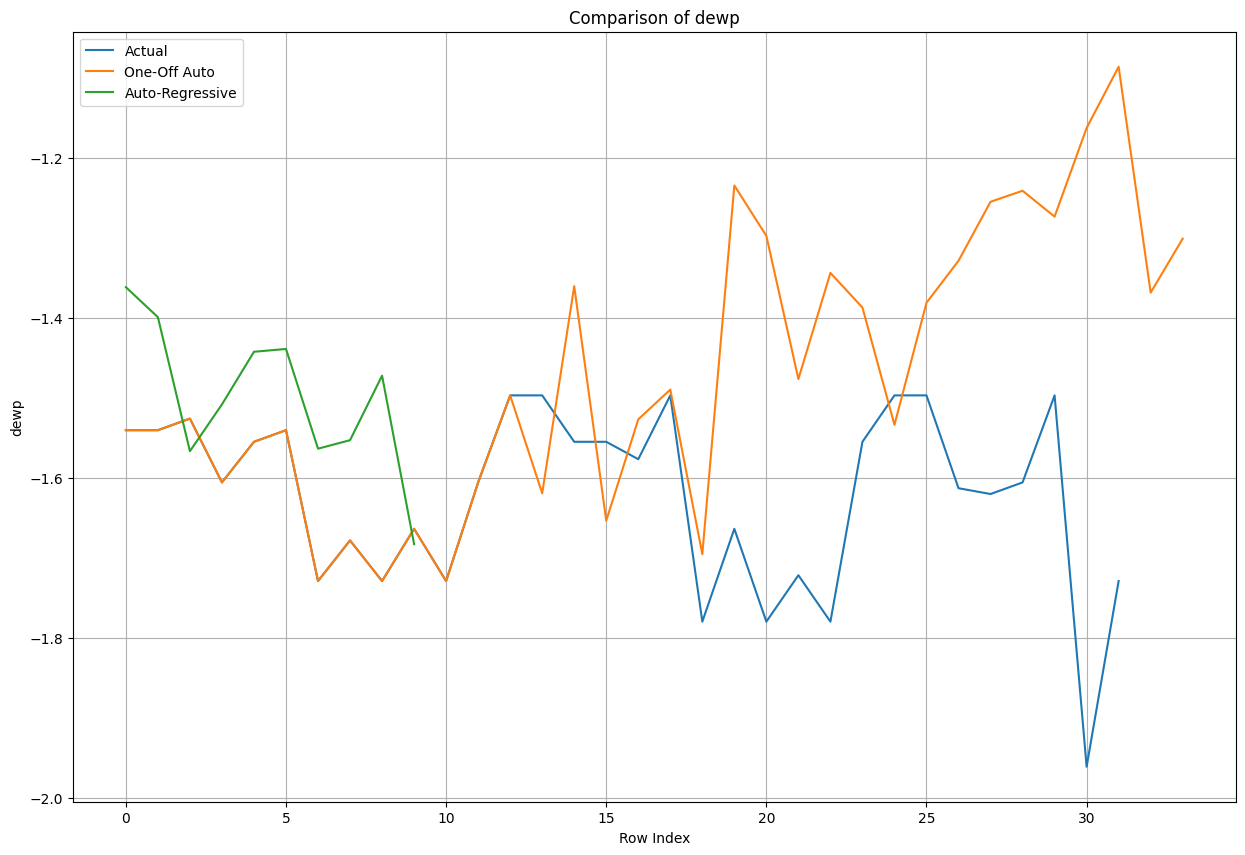

In [20]:
hp.plot_comparison(actual_df, auto_df, res_df, "dewp")